# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil
from typing import Tuple
import torch
import torch.nn as nn
from torchvision import models

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics
import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [6]:
noh_data = pd.read_csv('../metadata/NOH_image_dataset_2c.csv', index_col=0)
noh_data = noh_data[noh_data['data']=='NOH'].reset_index(drop=True)
noh_data

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path,new_label
0,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082014.jpg,processed_img/NOH_122/IMG_20230228_082014.jpg,1
1,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082225.jpg,processed_img/NOH_122/IMG_20230228_082225.jpg,1
2,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082229.jpg,processed_img/NOH_122/IMG_20230228_082229.jpg,1
3,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_081641.jpg,processed_img/NOH_122/IMG_20230228_081641.jpg,1
4,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082243.jpg,processed_img/NOH_122/IMG_20230228_082243.jpg,1
...,...,...,...,...,...,...,...,...,...
2043,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082639.jpg,processed_img/NOH_24/IMG_20230116_082639.jpg,1
2044,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082508.jpg,processed_img/NOH_24/IMG_20230116_082508.jpg,1
2045,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082541.jpg,processed_img/NOH_24/IMG_20230116_082541.jpg,1
2046,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082615.jpg,processed_img/NOH_24/IMG_20230116_082615.jpg,1


# Stats

In [7]:
noh_data[['new_label']].value_counts().sort_index()

new_label
0             382
1            1666
Name: count, dtype: int64

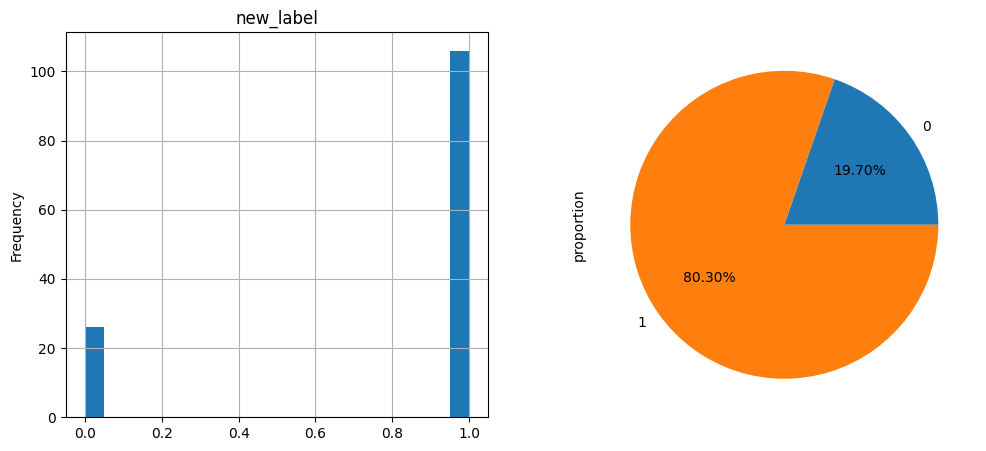

In [8]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=20, title='new_label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [9]:
noh_data.groupby(['dataset','new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='patient_id').astype(int)

new_label,0,1
dataset,,
test,7,32
train,11,45
val,8,29


## Per Image

In [10]:
noh_data.groupby(['dataset','new_label'])['filename'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='filename').astype(int)

new_label,0,1
dataset,,
test,104,540
train,158,673
val,120,453


In [11]:
img_ds = noh_data[['new_img_path', 'new_label', 'dataset']]
img_ds = img_ds.rename(columns={'new_img_path': 'img_path'})
img_ds['img_path'] = img_ds['img_path'].apply(lambda x: os.path.join(str(repo_fp), x.replace('./','')))
img_ds

,img_path,new_label,dataset
0,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
1,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
2,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
3,../data/processed_img/NOH_122/IMG_20230228_081...,1,train
4,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
...,...,...,...
2043,../data/processed_img/NOH_24/IMG_20230116_0826...,1,test
2044,../data/processed_img/NOH_24/IMG_20230116_0825...,1,test
2045,../data/processed_img/NOH_24/IMG_20230116_0825...,1,test
2046,../data/processed_img/NOH_24/IMG_20230116_0826...,1,test


## Transform

In [12]:
plt.rcParams["savefig.bbox"] = 'tight'

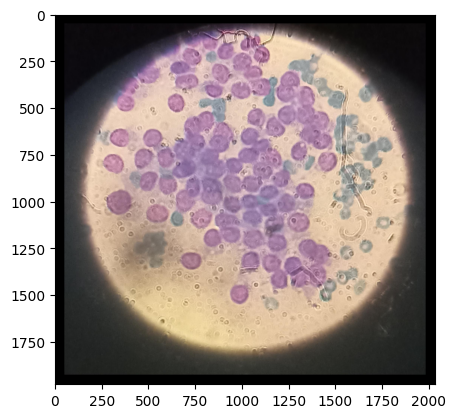

In [13]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [14]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

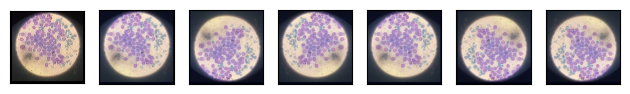

In [15]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [16]:
batch_size=32

# Dataset and DataLoader

In [17]:
# prompt: i need pytorch dataset that read from dataframe
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [19]:
trainset = NOHThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [20]:
valset = NOHThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [21]:
testset = NOHThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [22]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/processed_img/NOH_20/IMG_20230110_162833.jpg


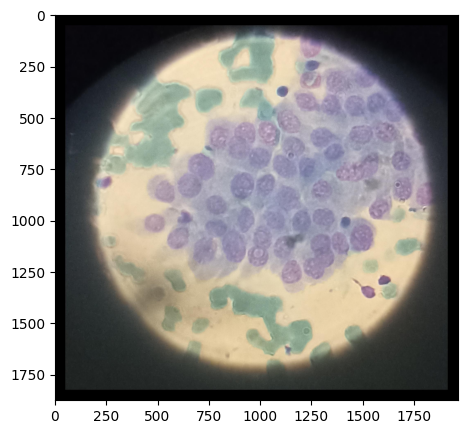

In [23]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


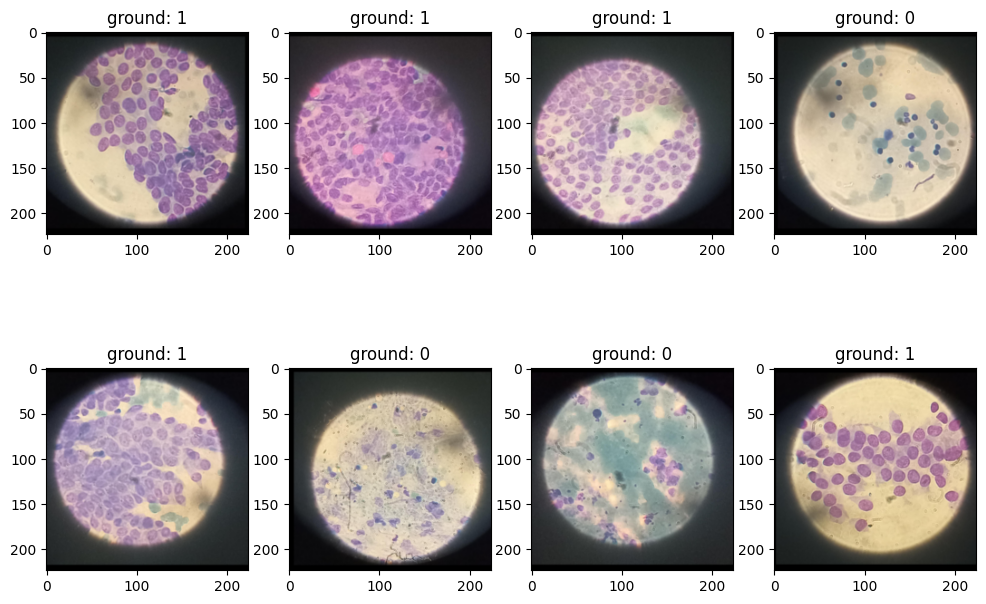

In [24]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [25]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_NOH_mobilenetv2_finetune')

2024-02-19 21:16:53.725888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:16:53.725924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:16:53.726962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 21:16:53.732328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 21:16:54.513720: W tensorflow/comp

# Load model

In [28]:
class MobileNetV2Model(nn.Module):
    """MobileNetV2 model class.

    Attributes:
        biases (torch.nn.Parameter): TODO: add description.
        mobilenet_features (torch.nn.Module): VGG feature map function.
        features (torch.nn.Sequential): hidden layers.
        classifier (torch.nn.Sequential): classifier.
    """
    def __init__(self):
        """MobileNetV2 model class constructor. 
        
        Args:
            params (dict): hyperparams.
        """
        super(MobileNetV2Model, self).__init__()
        
        # Reload MobileNetV2Model pretrained model
        mobilenet = models.mobilenet_v2(pretrained=1)
        mobilenet_checkpoint = torch.load('../repo/DavidDov/tele_cyto_models/hub/checkpoints/mobilenet_v2-b0353104.pth')
        mobilenet.load_state_dict(mobilenet_checkpoint)
        
        # Define MobileNetV2 feature extractor.
        self.mobilenet_features = mobilenet.features

        # Spatial average pooling operation: [B,C=1280,H=4,W=4] -> [B,C=1280,H=1,W=1].
        self.avg_pool_2d = torch.nn.AvgPool2d(kernel_size=4)

        # Final classifier.
        self.classifier = nn.Linear(in_features=1280,out_features=2)        
               
    def forward(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """VGG11 classifier forward pass.

        Args:
            z (torch.Tensor): [B, P, C, H, W] torch.tensor input. (B=batch, P=patches, CHW=image dims).

        Returns:
            malignancy_logits: [B*P, 1] float torch.tensor of malignancy logits.
            bethesda_logits: [B*P, 4] float torch.tensor of bethesda logits.
        """
        # Reshape input: [B, P, C, H, W] -> [B*P, C, H, W].
        # z = z.view([z.shape[0]*z.shape[1]] + list(z.shape[2:]))

        # Extract mobilenet features: [B*P, C, H, W] -> [B*P, 1280, 4, 4].
        z = self.mobilenet_features(z)

        # Spatial average pool: [B*P, 1280, 4, 4] -> [B*P, 1280, 1, 1].
        z = self.avg_pool_2d(z)

        # Reshape: [B*P, 1280, 1, 1] -> [B*P, 1280]
        z = z.view(z.shape[0], -1)   

        # Classifier: [B*P, 1280] -> [B*P, 1].
        z = self.classifier(z)
        
        return z

    
    def turn_train(self):
        self.mobilenet_features.grad = True
        self.classifier.grad = True
        
    def turn_eval(self):
        self.mobilenet_features.grad = False
        self.classifier.grad = False

In [29]:
model = MobileNetV2Model().to(device)

/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Test Input to VGG model

In [30]:
image = Image.open('/home/quan/work/thyroid/data/NOH/001.NguyeThiLan- Right/IMG_20221219_101351.jpg')
image = test_transform(image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)
image = image.to(device)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [31]:
output = model(image)

In [32]:
# model._fc = nn.Linear(model._fc.in_features, train_df['label'].nunique())
model.to(device);

In [33]:
model.classifier

Linear(in_features=1280, out_features=2, bias=True)

In [34]:
num_epochs = 5
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [36]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [37]:
def evaluate_dataset(model, ds_loader):
    model.turn_eval()
    loss = 0.0
    acc = 0.0
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    return acc

# If exist model, then evaluate before write new

In [38]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [39]:
baseline_model_path = '../model/NOH_2c/mobilenetv2_finetune.pt'

In [40]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)
    run_predict_testset()

In [41]:
best_val_acc

0.0

# Train model

In [42]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [44]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [45]:
for epoch in range(num_epochs):
    model.turn_train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.turn_eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), baseline_model_path)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.3617 	Train Acc: 0.8303 	Val Loss: 0.6599 	Val Acc: 0.7513


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.2514 	Train Acc: 0.9002 	Val Loss: 0.5355 	Val Acc: 0.8188


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.1658 	Train Acc: 0.9421 	Val Loss: 0.7434 	Val Acc: 0.8497


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.1302 	Train Acc: 0.9518 	Val Loss: 0.8199 	Val Acc: 0.8060


  0%|          | 0/26 [02:40<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.1362 	Train Acc: 0.9495 	Val Loss: 0.4763 	Val Acc: 0.8235


In [46]:
best_val_acc

0.8497365900383141

# Evaluate

In [47]:
evaluate_dataset(model, testloader)

  0%|          | 0/21 [00:00<?, ?it/s]

Test Loss: 0.0209 	Test Acc: 0.8527


0.8526785714285714